## Processa dados consolidados tanto de CO2 quanto CH4. 

TODO: mudar o nome das colunas (Xco2 / ch4) para deixar mais geral


In [5]:
import xarray as xr
# import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, MultiPolygon
import shapely.wkt



In [6]:
# # importando api earth engine
# import ee/home/mapbiomasar/Mayra/OCO2_L4/OCO2_L4/OCO2GriddedXCO2_20180709_v2_1605313492.nc
# # autorização com login 
# ee.Authenticate()xco2
# # iniciando a biblioteca
# ee.Initialize()

In [7]:

# shortcut to clean the crap 

file_name = '/home/mapbiomasar/Mayra/bag_ch4.nc'
nc_file = xr.open_dataset(file_name)
xch4 = nc_file[[
    'xch4', 'time'
]]
xch4 = xch4.to_dataframe()
xch4 = xch4.dropna()
xch4 = xch4.reset_index()
xch4 = xch4[['time','lat','lon','xch4']]
xch4

,time,lat,lon,xch4
0,2003-01-16 12:00:00,-82.5,-117.5,0.000002
1,2003-01-16 12:00:00,-82.5,-112.5,0.000002
2,2003-01-16 12:00:00,-82.5,-107.5,0.000002
3,2003-01-16 12:00:00,-82.5,-102.5,0.000002
4,2003-01-16 12:00:00,-82.5,-97.5,0.000002
...,...,...,...,...
152395,2020-06-16 00:00:00,77.5,67.5,0.000002
152396,2020-06-16 00:00:00,77.5,92.5,0.000002
152397,2020-06-16 00:00:00,77.5,97.5,0.000002
152398,2020-06-16 00:00:00,82.5,-87.5,0.000002


In [8]:

crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(xch4['lon'], xch4['lat'])]

points = gpd.GeoDataFrame(xch4, 
                          crs = crs, 
                          geometry = geometry)

# points


/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [9]:
# filter lat and long

# to avoid excessive processing to shapefiles we define a box
# covering South America


min_lat = -57.5858
max_lat =  15.5988
min_lon = -85.8360
max_lon = -35.8750

# back to original nomenclature
tmp = points.copy()

lat_filter = (tmp["lat"] >= min_lat) & (tmp["lat"] <= max_lat)
lon_filter = (tmp["lon"] >= min_lon) & (tmp["lon"] <= max_lon)

# tmp = tmp.loc[lat_filter & lon_filter]

points = tmp[lat_filter & lon_filter]

In [10]:
# # a small subset for testing

# points = points[0:1000]

In [11]:

buffers = points.buffer(2.5) #originally 0.5; is that degrees???
bounds = buffers.bounds

bounds['pixel_area'] = bounds.apply(
  lambda obj: Polygon(shell=[
    Point(obj['maxx'],obj['miny']),
    Point(obj['minx'],obj['miny']),
    Point(obj['minx'],obj['maxy']),
    Point(obj['maxx'],obj['maxy']),
    Point(obj['maxx'],obj['miny']),
  ]),
  axis=1
)

# adding indexes to merge dataframes
points.insert(0, 'New_ID', range(1, 1 + len(points)))
bounds.insert(0, 'New_ID', range(1, 1 + len(bounds)))

my_merge = bounds.merge(points, on='New_ID')


/tmp/ipykernel_37446/641316333.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers = points.buffer(2.5) #originally 0.5; is that degrees???


In [12]:
def ToShapeFile(gdf,yr,mon):
  gdf = gpd.GeoDataFrame(
    gdf,
    crs = {'init':'EPSG:4326'}, 
    geometry = [a for a in gdf['pixel_area']]                               
    )
  gdf = gdf.reset_index()
  gdf = gdf.loc[:,gdf.columns.isin(['xch4', 'geometry'])]
  gdf.to_file('/home/mapbiomasar/MJT/shapefiles/xch4_merged_mips' + str(yr) +'_' + str(mon) + '.shp')

In [13]:
crs

{'init': 'EPSG:4326'}

In [14]:
import datetime
import time
# do not show these annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


df = my_merge.copy()

df['Date'] = pd.to_datetime(df['time'])
df = df.set_index(df['Date'])
df = df.sort_index()
df = df[['lat','lon','pixel_area','xch4']]

year = list(range(2003,2021))
month = list(range(1,13))
start_time = time.time()
for yr in year:
    print('Processing ', yr, ' shapefiles')
    for mon in month:
        # shapefile_name = '/home/mapbiomasar/MJT/shapefiles/oco2_merged_mips' + str(yr) +'_' + str(mon) +'.shp'
        # print(shapefile_name)
        # we keep within a month
        date_min = datetime.datetime(yr, mon, 1)
        date_max = datetime.datetime(yr, mon, 25)
        to_process = df[date_min:date_max]
        if to_process.empty:        
            print('Dataframe from ', str(yr)+str(mon), 'is empty!') 
        else:
            ToShapeFile(to_process,yr,mon)

print('Processing time:', time.time()-start_time)

Processing  2003  shapefiles
Processing  2004  shapefiles
Processing  2005  shapefiles
Processing  2006  shapefiles
Processing  2007  shapefiles
Processing  2008  shapefiles
Processing  2009  shapefiles
Processing  2010  shapefiles
Processing  2011  shapefiles
Processing  2012  shapefiles
Processing  2013  shapefiles
Processing  2014  shapefiles
Processing  2015  shapefiles
Dataframe from  20151 is empty!
Processing  2016  shapefiles
Processing  2017  shapefiles
Processing  2018  shapefiles
Processing  2019  shapefiles
Processing  2020  shapefiles
Dataframe from  20207 is empty!
Dataframe from  20208 is empty!
Dataframe from  20209 is empty!
Dataframe from  202010 is empty!
Dataframe from  202011 is empty!
Dataframe from  202012 is empty!
Processing time: 3.955477476119995


In [15]:
df

,lat,lon,pixel_area,xch4
Date,,,,
2003-01-16 12:00:00,-57.5,-47.5,"POLYGON ((-45 -60, -50 -60, -50 -55, -45 -55, ...",0.000002
2003-01-16 12:00:00,-57.5,-42.5,"POLYGON ((-40 -60, -45 -60, -45 -55, -40 -55, ...",0.000002
2003-01-16 12:00:00,-57.5,-37.5,"POLYGON ((-35 -60, -40 -60, -40 -55, -35 -55, ...",0.000002
2003-01-16 12:00:00,-52.5,-72.5,"POLYGON ((-70 -55, -75 -55, -75 -50, -70 -50, ...",0.000002
2003-01-16 12:00:00,-52.5,-67.5,"POLYGON ((-65 -55, -70 -55, -70 -50, -65 -50, ...",0.000002
...,...,...,...,...
2020-06-16 00:00:00,7.5,-37.5,"POLYGON ((-35 5, -40 5, -40 10, -35 10, -35 5))",0.000002
2020-06-16 00:00:00,12.5,-57.5,"POLYGON ((-55 10, -60 10, -60 15, -55 15, -55 ...",0.000002
2020-06-16 00:00:00,12.5,-52.5,"POLYGON ((-50 10, -55 10, -55 15, -50 15, -50 ...",0.000002


In [16]:
my_merge


,New_ID,minx,miny,maxx,maxy,pixel_area,time,lat,lon,xch4,geometry
0,1,-50.0,-60.0,-45.0,-55.0,"POLYGON ((-45 -60, -50 -60, -50 -55, -45 -55, ...",2003-01-16 12:00:00,-57.5,-47.5,0.000002,POINT (-47.50000 -57.50000)
1,2,-45.0,-60.0,-40.0,-55.0,"POLYGON ((-40 -60, -45 -60, -45 -55, -40 -55, ...",2003-01-16 12:00:00,-57.5,-42.5,0.000002,POINT (-42.50000 -57.50000)
2,3,-40.0,-60.0,-35.0,-55.0,"POLYGON ((-35 -60, -40 -60, -40 -55, -35 -55, ...",2003-01-16 12:00:00,-57.5,-37.5,0.000002,POINT (-37.50000 -57.50000)
3,4,-75.0,-55.0,-70.0,-50.0,"POLYGON ((-70 -55, -75 -55, -75 -50, -70 -50, ...",2003-01-16 12:00:00,-52.5,-72.5,0.000002,POINT (-72.50000 -52.50000)
4,5,-70.0,-55.0,-65.0,-50.0,"POLYGON ((-65 -55, -70 -55, -70 -50, -65 -50, ...",2003-01-16 12:00:00,-52.5,-67.5,0.000002,POINT (-67.50000 -52.50000)
...,...,...,...,...,...,...,...,...,...,...,...
13883,13884,-40.0,5.0,-35.0,10.0,"POLYGON ((-35 5, -40 5, -40 10, -35 10, -35 5))",2020-06-16 00:00:00,7.5,-37.5,0.000002,POINT (-37.50000 7.50000)
13884,13885,-60.0,10.0,-55.0,15.0,"POLYGON ((-55 10, -60 10, -60 15, -55 15, -55 ...",2020-06-16 00:00:00,12.5,-57.5,0.000002,POINT (-57.50000 12.50000)
13885,13886,-55.0,10.0,-50.0,15.0,"POLYGON ((-50 10, -55 10, -55 15, -50 15, -50 ...",2020-06-16 00:00:00,12.5,-52.5,0.000002,POINT (-52.50000 12.50000)
13886,13887,-50.0,10.0,-45.0,15.0,"POLYGON ((-45 10, -50 10, -50 15, -45 15, -45 ...",2020-06-16 00:00:00,12.5,-47.5,0.000002,POINT (-47.50000 12.50000)


In [17]:
# # new geopandas with the variables of interest
# gdf = my_merge.copy()
# gdf = gpd.GeoDataFrame(
#   gdf,
#   crs = crs, 
#   geometry = [a for a in gdf['pixel_area']]                               
#   )
# gdf = gdf.reset_index()
# gdf = gdf.loc[:,gdf.columns.isin(['xco2', 'geometry'])]

# # print('--> TYPE: ',type(gdf))
# gdf


<AxesSubplot:>

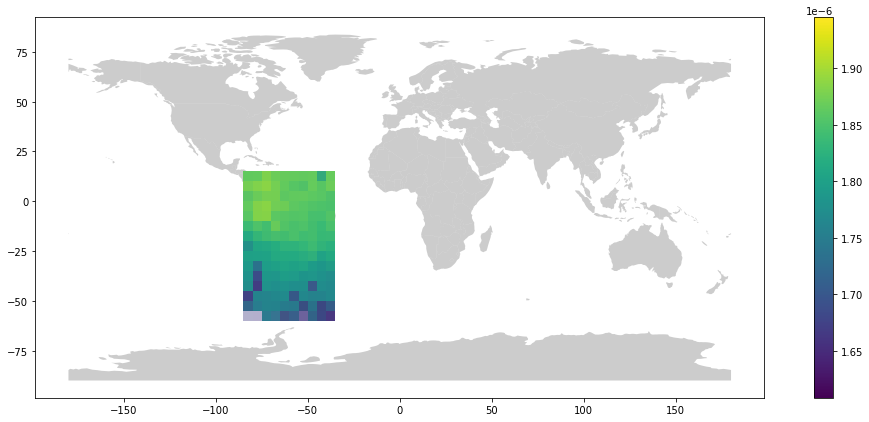

In [18]:
# testing the view

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(18, 7))


# ax.set_xlim(178.0, 181.0)
# ax.set_ylim(20.0, 23.0)
world.plot(ax=ax, alpha=0.4, color='grey')

gpd.GeoDataFrame(
  my_merge,
  crs = crs, 
  geometry = [a for a in my_merge['pixel_area']]                                
  ).plot(column='xch4', ax=ax, legend=True,alpha = 0.4)

# gpd.GeoDataFrame(
#   points,
#   crs = crs, 
#   geometry = [a for a in points['geometry']]                                
#   ).plot(column='xco2', ax=ax)



# plt.title('xco2 from Mayra')


In [19]:


  print('--> TYPE: ',type(gdf))



NameError: name 'gdf' is not defined

<module 'geopandas' from '/home/mapbiomasar/miniconda3/envs/geoproc/lib/python3.9/site-packages/geopandas/__init__.py'>

### Part 2: reprocessing and splitting files

TODO: separar os arquivos por meses para subir ao GEE



In [ ]:
# # summarizing table
# print(len(my_merge))
# tmp = my_merge.groupby(['time'])['xco2'].mean()
# len(tmp)

11275


209

In [ ]:
# looping per year and month


850

In [ ]:
my_merge

,New_ID,minx,miny,maxx,maxy,pixel_area,time,lat,lon,xco2,geometry
0,1,-70.0,-45.0,-65.0,-40.0,"POLYGON ((-65 -45, -70 -45, -70 -40, -65 -40, ...",2003-01-16 12:00:00,-42.5,-67.5,0.000374,"POLYGON ((-65.00000 -45.00000, -70.00000 -45.0..."
1,2,-75.0,-40.0,-70.0,-35.0,"POLYGON ((-70 -40, -75 -40, -75 -35, -70 -35, ...",2003-01-16 12:00:00,-37.5,-72.5,0.000375,"POLYGON ((-70.00000 -40.00000, -75.00000 -40.0..."
2,3,-70.0,-40.0,-65.0,-35.0,"POLYGON ((-65 -40, -70 -40, -70 -35, -65 -35, ...",2003-01-16 12:00:00,-37.5,-67.5,0.000373,"POLYGON ((-65.00000 -40.00000, -70.00000 -40.0..."
3,4,-65.0,-40.0,-60.0,-35.0,"POLYGON ((-60 -40, -65 -40, -65 -35, -60 -35, ...",2003-01-16 12:00:00,-37.5,-62.5,0.000374,"POLYGON ((-60.00000 -40.00000, -65.00000 -40.0..."
4,5,-60.0,-40.0,-55.0,-35.0,"POLYGON ((-55 -40, -60 -40, -60 -35, -55 -35, ...",2003-01-16 12:00:00,-37.5,-57.5,0.000375,"POLYGON ((-55.00000 -40.00000, -60.00000 -40.0..."
...,...,...,...,...,...,...,...,...,...,...,...
11270,11271,-45.0,5.0,-40.0,10.0,"POLYGON ((-40 5, -45 5, -45 10, -40 10, -40 5))",2020-06-16 00:00:00,7.5,-42.5,0.000415,"POLYGON ((-40.00000 5.00000, -45.00000 5.00000..."
11271,11272,-40.0,5.0,-35.0,10.0,"POLYGON ((-35 5, -40 5, -40 10, -35 10, -35 5))",2020-06-16 00:00:00,7.5,-37.5,0.000414,"POLYGON ((-35.00000 5.00000, -40.00000 5.00000..."
11272,11273,-50.0,10.0,-45.0,15.0,"POLYGON ((-45 10, -50 10, -50 15, -45 15, -45 ...",2020-06-16 00:00:00,12.5,-47.5,0.000415,"POLYGON ((-45.00000 10.00000, -50.00000 10.000..."
11273,11274,-45.0,10.0,-40.0,15.0,"POLYGON ((-40 10, -45 10, -45 15, -40 15, -40 ...",2020-06-16 00:00:00,12.5,-42.5,0.000416,"POLYGON ((-40.00000 10.00000, -45.00000 10.000..."


In [ ]:
print('--> ',type(gdf))

gdf.to_file('/home/mapbiomasar/MJT/notebooks/smallGridMerged.shp')
